## Spatial Bootstrap and Uncertainty

In [13]:
# Import Packages/Libraries
import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python 
import pandas as pd
import seaborn as sns
import numpy as np                        # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
from scipy import stats                   # summary statistics
import astropy.convolution.convolve as convolve
import scipy.signal as signal             # kernel for moving window calculation
import math                               # trig etc.
import random

In [4]:
df = pd.read_csv('df_nscored.csv')
df_sand = pd.read_csv('dfsand_nscored.csv')
df_shale = pd.read_csv('dfshale_nscored.csv')

In [5]:
ind_vario = np.load('indicatorvariogram.npy').item()
sandpor_vario = np.load('sandporosityvariogram.npy').item()
shalepor_vario = np.load('shaleporosityvariogram.npy').item()
sandperm_vario = np.load('sandpermeabilityvariogram.npy').item()
shaleperm_vario = np.load('shalepermeabilityvariogram.npy').item()

In [6]:
por_trend = np.load('porositytrend.npy')
perm_trend = np.load('permeabilitytrend.npy')

In [7]:
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=18)
plt.rc('figure', titlesize=18)
plt.rc('legend', fontsize=16)

In [10]:
# functions for spatial bootstrap
from numba import jit # for numerical speed up
import scipy
@jit(nopython=True)
def cova2(x1, y1, x2, y2, nst, c0, pmx, cc, aa, it, ang, anis, rotmat, maxcov):
    """Calculate the covariance associated with a variogram model specified by a
    nugget effect and nested variogram structures.
    :param x1: x coordinate of first point
    :param y1: y coordinate of first point
    :param x2: x coordinate of second point
    :param y2: y coordinate of second point
    :param nst: number of nested structures (maximum of 4)
    :param c0: isotropic nugget constant (TODO: not used)
    :param pmx: TODO
    :param cc: multiplicative factor of each nested structure
    :param aa: parameter `a` of each nested structure
    :param it: TODO
    :param ang: TODO: not used
    :param anis: TODO
    :param rotmat: rotation matrices
    :param maxcov: TODO
    :return: TODO
    """
    EPSLON = 0.000001

    # Check for very small distance
    dx = x2 - x1
    dy = y2 - y1

    if (dx * dx + dy * dy) < EPSLON:
        cova2_ = maxcov
        return cova2_

    # Non-zero distance, loop over all the structures
    cova2_ = 0.0
    for js in range(0, nst):
        # Compute the appropriate structural distance
        dx1 = dx * rotmat[0, js] + dy * rotmat[1, js]
        dy1 = (dx * rotmat[2, js] + dy * rotmat[3, js]) / anis[js]
        h = math.sqrt(max((dx1 * dx1 + dy1 * dy1), 0.0))
        if it[js] == 1:
            # Spherical model
            hr = h / aa[js]
            if hr < 1.0:
                cova2_ = cova2_ + cc[js] * (1.0 - hr * (1.5 - 0.5 * hr * hr))
        elif it[js] == 2:
            # Exponential model
            cova2_ = cova2_ + cc[js] * np.exp(-3.0 * h / aa[js])
        elif it[js] == 3:
            # Gaussian model
            hh = -3.0 * (h * h) / (aa[js] * aa[js])
            cova2_ = cova2_ + cc[js] * np.exp(hh)
        elif it[js] == 4:
            # Power model
            cov1 = pmx - cc[js] * (h ** aa[js])
            cova2_ = cova2_ + cov1
    return cova2_

@jit(nopython=True)
def setup_rotmat(c0, nst, it, cc, ang, pmx):
    """Setup rotation matrix.
    :param c0: nugget constant (isotropic)
    :param nst: number of nested structures (max. 4)
    :param it: TODO
    :param cc: multiplicative factor of each nested structure
    :param ang: TODO
    :param pmx: TODO
    :return: TODO
    """
    PI = 3.14159265
    DTOR = PI / 180.0

    # The first time around, re-initialize the cosine matrix for the variogram
    # structures
    rotmat = np.zeros((4, nst))
    maxcov = c0
    for js in range(0, nst):
        azmuth = (90.0 - ang[js]) * DTOR
        rotmat[0, js] = math.cos(azmuth)
        rotmat[1, js] = math.sin(azmuth)
        rotmat[2, js] = -1 * math.sin(azmuth)
        rotmat[3, js] = math.cos(azmuth)
        if it[js] == 4:
            maxcov = maxcov + pmx
        else:
            maxcov = maxcov + cc[js]
    return rotmat, maxcov

def n_effective(df,xcol,ycol,seed,nreal,vario):
    """Calculate the number of effective data from spatial locations and spatial continuity model
    Used in bootstrap to account for spatial continuity, use n effective instead of number of data
    :param df: source DataFrame
    :param xcol: column with the X locations
    :param ycol: column with the Y locations
    :param seed: random number seed for the random sampling
    :param nreal: number of realizations to sample the variance of the average 
    :param vario: variogram model as a dictionary, see the GeostatsPy Package's GSLIB.make_variogram() function 
    :return: n_eff as effective number of data
    """ 

# Set constants
    np.random.seed(seed)
    PMX = 9999.9
    
# load the variogram
    nst = vario['nst']
    cc = np.zeros(nst); aa = np.zeros(nst); it = np.zeros(nst)
    ang = np.zeros(nst); anis = np.zeros(nst)
    c0 = vario['nug']; 
    cc[0] = vario['cc1']; it[0] = vario['it1']; ang[0] = vario['azi1']; 
    aa[0] = vario['hmaj1']; anis[0] = vario['hmin1']/vario['hmaj1'];
    if nst == 2:                                   # include 2nd structure if present (optional)
        cc[1] = vario['cc2']; it[1] = vario['it2']; ang[1] = vario['azi2']; 
        aa[1] = vario['hmaj2']; anis[1] = vario['hmin2']/vario['hmaj2'];
    
# Set up the rotation matrix
    rotmat, maxcov = setup_rotmat(c0,nst,it,cc,ang,PMX)
    
# Load the data
    nd = len(df)
    x = df[xcol].values
    y = df[ycol].values
    
# Calculate Symmetric Covariance Array - assuming variogram with spherical structure with range specified
    cov = np.zeros((nd,nd))
    var_range = 100.0
    for i in range(0, nd):
        x1 = x[i]; y1 = y[i]
        for j in range(0, nd):
            x2 = x[j]; y2 = y[j]
            cova = cova2(x1, y1, x2, y2, nst, c0, PMX, cc, aa, it, ang, anis, rotmat, maxcov)
            cov[i,j] = cova
            
# Lower and upper deconvolution            
    P, L, U = scipy.linalg.lu(cov) 
    
# Build realization and calculate the average    
    average_array = np.zeros(nreal)
    rand = np.zeros((nd)) 
    for l in range(0, nreal):
        rand = np.random.normal(loc = 0.0, scale = 1.0, size = nd)
        realization = np.matmul(L,rand)
        average_array[l] = np.average(realization)
        
# Back out the number of effecitve data useing the standard error in the average
    var_average = np.var(average_array)
    n_eff = max(min(1.0/var_average, nd),1.0)    # filter n effective less than 1.0 or greater than number of data
    
    return n_eff
    

### Uncertainty in Facies Proportions

In [11]:
# calculating n_effective
n_eff = n_effective(df,'X','Y',seed=1,nreal=1000,vario=ind_vario)
print('Number of effective data = ' + str(round(n_eff,2)) + ' / ' + str(len(df)) + '.')

Number of effective data = 20.02 / 217.


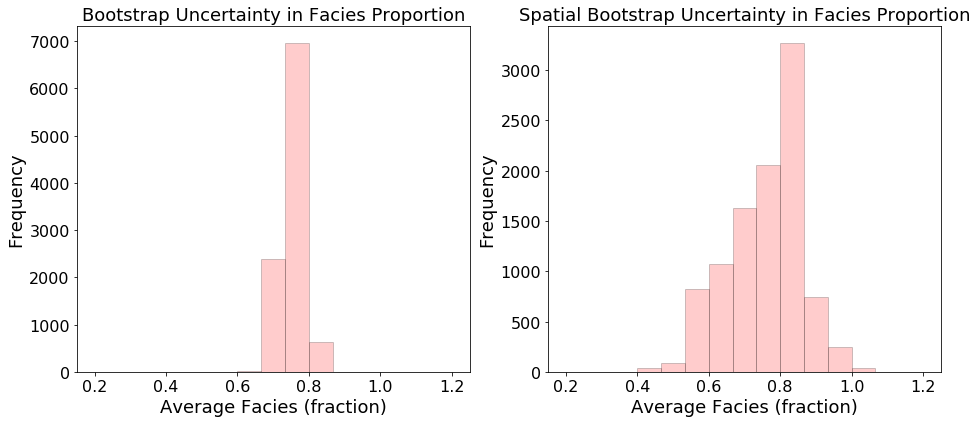

In [14]:
# comparing bootstrap and spatial boostrap
L = 10000                                      # set the number of realizations for uncertainty calculation
facies_mean = np.zeros(L); spatial_mean = np.zeros(L) # declare arrays to hold the realizations of the statistics
P10 = np.zeros(L)                          
P50 = np.zeros(L); P90 = np.zeros(L)                         
for l in range(0, L):                          # loop over realizations
    samples = random.choices(df['Facies'].values, weights=None, cum_weights=None, k=len(df))
    spatial_samples = random.choices(df['Facies'].values, weights=None, cum_weights=None, k=int(n_eff))

    facies_mean[l] = np.average(samples)
    spatial_mean[l] = np.average(spatial_samples)
    
plt.subplot(121)
GSLIB.hist_st(facies_mean,0.2,1.2,False,False,15,None,
              'Average Facies (fraction)','Bootstrap Uncertainty in Facies Proportion')

plt.subplot(122)
GSLIB.hist_st(spatial_mean,0.2,1.2,False,False,15,None,
              'Average Facies (fraction)','Spatial Bootstrap Uncertainty in Facies Proportion')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

### Uncertainty in porosity mean (by-facies)

In [17]:
# calculating n_effective
sandpor_n_eff = n_effective(df_sand,'X','Y',seed=1,nreal=1000,vario=sandpor_vario)
print('Number of effective data (Sandstone Porosity) = ' + str(round(sandpor_n_eff,2)) + ' / ' + str(len(df)) + '.')

Number of effective data (Sandstone Porosity) = 91.61 / 217.


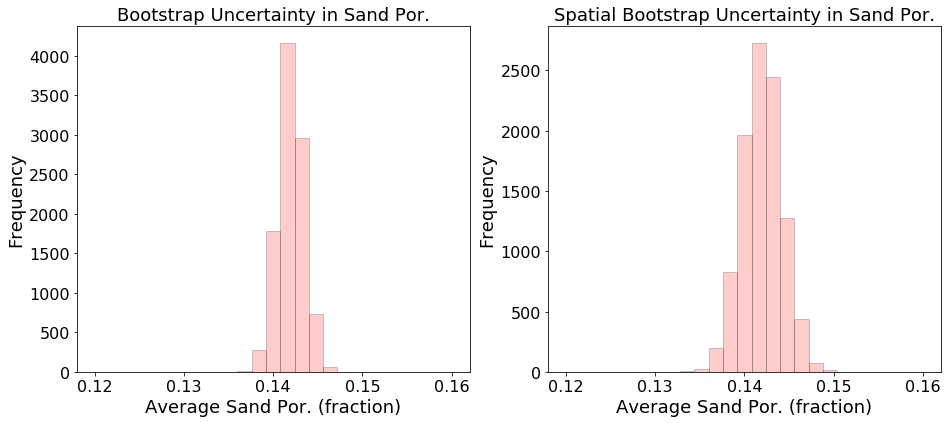

In [28]:
# comparing bootstrap and spatial boostrap
L = 10000                                      # set the number of realizations for uncertainty calculation
sandpor_mean = np.zeros(L); spatial_sandpormean = np.zeros(L) # declare arrays to hold the realizations of the statistics
P10 = np.zeros(L)                          
P50 = np.zeros(L); P90 = np.zeros(L)                         
for l in range(0, L):                          # loop over realizations
    samples = random.choices(df_sand['Porosity'].values,
                             weights=None, cum_weights=None, k=len(df))
    
    spatial_samples = random.choices(df_sand['Porosity'].values,
                                     weights=None, cum_weights=None, k=int(sandpor_n_eff))

    sandpor_mean[l] = np.average(samples)
    spatial_sandpormean[l] = np.average(spatial_samples)
    
plt.subplot(121)
GSLIB.hist_st(sandpor_mean,0.12,0.16,False,False,25,None,
              'Average Sand Por. (fraction)','Bootstrap Uncertainty in Sand Por.')

plt.subplot(122)
GSLIB.hist_st(spatial_sandpormean,0.12,0.16,False,False,25,None,
              'Average Sand Por. (fraction)','Spatial Bootstrap Uncertainty in Sand Por.')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

In [18]:
# calculating n_effective
shalepor_n_eff = n_effective(df_shale,'X','Y',seed=1,nreal=1000,vario=shalepor_vario)
print('Number of effective data (Shale Porosity) = ' + str(round(shalepor_n_eff,2)) + ' / ' + str(len(df)) + '.')

Number of effective data (Shale Porosity) = 42.14 / 217.


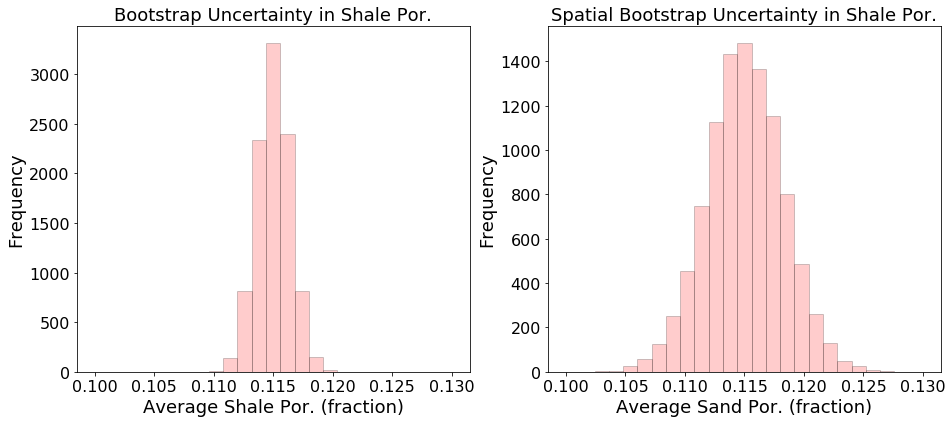

In [33]:
# comparing bootstrap and spatial boostrap
L = 10000                                      # set the number of realizations for uncertainty calculation
shalepor_mean = np.zeros(L); spatial_shalepormean = np.zeros(L) # declare arrays to hold the realizations of the statistics
P10 = np.zeros(L)                          
P50 = np.zeros(L); P90 = np.zeros(L)                         
for l in range(0, L):                          # loop over realizations
    samples = random.choices(df_shale['Porosity'].values,
                             weights=None, cum_weights=None, k=len(df))
    
    spatial_samples = random.choices(df_shale['Porosity'].values,
                                     weights=None, cum_weights=None, k=int(shalepor_n_eff))

    shalepor_mean[l] = np.average(samples)
    spatial_shalepormean[l] = np.average(spatial_samples)
    
plt.subplot(121)
GSLIB.hist_st(shalepor_mean,0.10,0.13,False,False,25,None,
              'Average Shale Por. (fraction)','Bootstrap Uncertainty in Shale Por.')

plt.subplot(122)
GSLIB.hist_st(spatial_shalepormean,0.10,0.13,False,False,25,None,
              'Average Sand Por. (fraction)','Spatial Bootstrap Uncertainty in Shale Por.')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()